# Neural Network from the Ground-Up

- Sven Hockers I6375151
- Emil Künstner I 6377110

# Class diagram

![Class Diagram Image](class_diagram.png)

# Class Diagram Description

This class diagram represents a basic structure for the Neural Network, detailing classes and their relationships.

## 1. **FFN (Feedforward Neural Network)**
   - **Attributes**:
     - `activation`: Holds an object that defines the activation function for the network.
     - `learningRate`: A float that specifies the learning rate for the training process.
     - `layers`: A list that contains instances of the `Layer` class.
   - **Methods**:
     - `__init__(dimensions: list[int], activation="sigmoid", alpha=1)`: Initializes the neural network with specified dimensions, default activation function (sigmoid), and a parameter `alpha` (e.g. the `learningRate`).
     - `displayModel()`: Outputs or displays the model structure.
     - `forward(input: list[float]) -> list[float]`: Takes an input list of floats and returns the forward pass result through the network.
     - `backward(input: list[float], y_true: list[float]) -> void`: Performs backpropagation, adjusting the network based on the input and true values (`y_true`).
     - `train(X: list[float], y: list[float], max_iterations=1000, graph_points=100) -> void`: Trains the network on given data `X` and labels `y` over a specified number of iterations with optional graph points.

   - **Relationships**:
     - **Uses**: The `FFN` class uses the `ActivationFunction` class, allowing different activation functions to be applied within the network.
     - **Contains**: Contains instances of the `Layer` class, representing the different layers within the neural network.

## 2. **Layer**
   - **Attributes**:
     - `weights`: An `np.ndarray` representing the weights of the layer.
     - `bias`: An `np.ndarray` for the bias values in the layer.
   - **Methods**:
     - `__init__(NumberOfInputs: int, NumberOfNodes: int)`: Initializes a layer with a specified number of inputs and nodes.
     - `getLayer() -> np.ndarray`: Returns the current layer structure (e.g., weights).
     - `compute(input: np.array, activation: object) -> np.array`: Computes the output of the layer by applying weights, biases, and the activation function to the input.
   - **Relationships**:
     - **Containment**: Layers are contained within the `FFN` class, enabling multi-layer architectures within the neural network.

## 3. **ActivationFunction**
   - **Attributes**:
     - None listed explicitly, but it is initialized with an activation function string.
   - **Methods**:
     - `__init__(activation_func: str)`: Initializes the `ActivationFunction` class with a specified activation function type.
   - **Relationships**:
     - This is an abstract or base class that other specific activation function classes inherit from.

## 4. **Activation Function Subclasses**
   These subclasses inherit from `ActivationFunction` and implement specific activation functions:

   - **SigmoidActivation**
     - **Methods**:
       - `forward(input: np.array) -> np.array`: Performs the forward pass for the sigmoid activation function.
       - `backward(input: np.array) -> np.array`: Calculates the derivative or backward pass for the sigmoid function.

   - **TanhActivation**
     - **Methods**:
       - `forward(input: np.array) -> np.array`: Applies the tanh activation function in the forward pass.
       - `backward(input: np.array) -> np.array`: Computes the derivative or backward pass for the tanh function.

   - **ReLUActivation**
     - **Methods**:
       - `forward(input: np.array) -> np.array`: Executes the ReLU activation in the forward pass.
       - `backward(input: np.array) -> np.array`: Performs the backward pass for the ReLU activation function, likely setting gradients to zero where input is negative.

   - **Relationships**:
     - Each subclass "switches to" or overrides the abstract methods of `ActivationFunction` to implement specific activation behaviors.

Init by importing `numpy` (this is mainly used) and `matplotlib` (only used to show the convergence). 
Note we make use of some `@staticmethods` which have been grouped by there activation function (e.g. Sigmoid, TANH), this way it allows for modular implementation of the activation function without having to create an instance of the class. This simplifies the integration of these various modules in the classes discussed later in the notebook.

In [ ]:
import numpy as np  # required for most computations
import json         # Used to return the model params
import matplotlib.pyplot as plt # Used to display the training loss / itterations
# import random       # Used to randomly move through the training set / Replaced by np.random

# Activation functions defined below:
class SigmoidActivation:
    @staticmethod
    def getName() -> str:
        return "Sigmoid"

    @staticmethod
    def forward(input) -> np.array:
        ex = np.exp(input)
        return ex / (ex + 1)
    
    @staticmethod
    def backward(input) -> np.array:
        sigmoid = SigmoidActivation.forward(input)
        return sigmoid * (1 - sigmoid)
    
class TanhActivation:
    @staticmethod
    def getName() -> str:
        return "Tanh"

    @staticmethod
    def forward(input) -> np.array:
        ex = np.exp(input)
        ex_min = np.exp(-1*input)
        return (ex - ex_min) / (ex + ex_min)
    
    @staticmethod
    def backward(input) -> np.array:
        tanh_output = TanhActivation.forward(input)
        return 1 - tanh_output ** 2
    
class ReLU:
    @staticmethod
    def getName() -> str:
        return "ReLu"
        
    @staticmethod
    def forward(input) -> np.array:
        return np.maximum(0, input)
    
    @staticmethod
    def backward(input) -> np.array:
        return np.where(input <= 0, 0, 1)

# Argmax function used in the .predict method
def argmax(x: np.array) -> np.array:
    y = np.zeros_like(x)
    y[np.argmax(x)] = 1
    return y

# This function is used to check the activation function selected for the NN (if exists and if yes return the right object)
def checkActivation(activation_func) -> object:
    if activation_func == "sigmoid":
            activation = SigmoidActivation
    elif activation_func == "tanh":
        activation = TanhActivation
    elif activation_func == "relu":
        activation = ReLU
    else:
        raise AttributeError("Chosen activation function does not exist.")
    return activation


Here we define the `layer` class which is a subset of a neural network (i.e. neural network is a sum of layers).

#### Attributes
- **`weights`**: A 2D NumPy array (`np.ndarray`) containing the weights of the layer. Its shape is `(numberOfInputs, numberOfNodes)`, where `numberOfInputs` is the number of input connections, and `numberOfNodes` is the number of nodes (neurons) in the layer. The weights are initialized randomly.
- **`bias`**: A 1D NumPy array (`np.ndarray`) containing the biases for each node in the layer. Its length is `numberOfNodes`, and each value is initialized randomly.

#### Methods
- **`__init__`**:
   - Initializes a new instance of the `Layer` class.
   - Parameters:
     - `numberOfInputs` (int): The number of input connections to each node in the layer.
     - `numberOfNodes` (int): The number of nodes (neurons) in the layer.
   - This method initializes the weights and biases with random values based on the specified number of inputs and nodes.

- **`getLayer`**:
   - Returns the `weights` attribute of the layer.
   - This provides direct access to the current weights matrix of the layer.

- **`compute`**:
   - Computes the output of the layer for a given input, applying weights, biases, and an activation function.
   - Parameters:
     - `inputs` (np.array): A NumPy array representing the input data to the layer.
     - `activation` (object): An activation function object with a `forward` method.
   - Returns:
     - A NumPy array representing the layer's output after applying the weights, biases, and activation function.
   - **Functionality**:
     - Computes `W = np.dot(inputs, self.weights) + self.bias`, where `inputs` into the layer is multiplied by `weights` of the layer and the `bias` is added.
     - Passes the result `W` through the provided activation function using `activation.forward(W)` to produce the final output.


In [28]:
class layer:
    def __init__(self, numberOfInputs: int, numberOfNodes: int):
        self.weigths = np.random.rand(numberOfInputs, numberOfNodes)
        self.bias = np.random.rand(numberOfNodes)

    def getLayer(self):
        return(self.weigths)
    
    def compute(self, inputs: np.array, activation: object) -> np.array:
        W = np.dot(inputs, self.weigths) + self.bias
        return  activation.forward(W)

Below the `FFN` class represents a Feed Forward Neural Network which leverages the classes defined before to implement a modular neural network.

#### Attributes
- **`activation`**: An activation function object, determined by the `activation` parameter. It provides both `forward` and `backward` methods for activating neurons and computing derivatives.
- **`learningRate`**: A float that specifies the learning rate for the network, controlling the step size for weight updates during training.
- **`layers`**: A list containing instances of the `Layer` class, representing each layer in the network. Layers are initialized based on the dimensions specified during network initialization.

#### Methods

- **`__init__`**:
   - Initializes the neural network with a specified layer structure and activation function.
   - Parameters:
     - `dimensions` (list[int]): A list defining the number of nodes in each layer, including input and output layers.
     - `activation` (str): The activation function to use, defaulting is "sigmoid".
     - `alpha` (float): The learning rate for training, defaulting is 1.
   - Raises an error if `dimensions` has fewer than two elements (because at minimum an input and output layer are required).
   - Initializes each layer based on the specified dimensions and appends them to `self.layers`.

- **`displayModel`**:
   - Displays the structure of the neural network in JSON format.
   - Outputs information about the number of layers, the nodes, weigths and biases in each layer.

- **`forward`**:
   - Performs a forward pass through the network levarging the `compute` method of the `layer` class itterating over the layers of the neural network.
   - Parameters:
     - `input` (list[float]): A list of input values.
   - Returns:
     - A list of output values after passing through all layers and applying activation functions.

- **`predict`**:
   - In essence the logic of this method is the same as the `forward` method described before, the main difference is that the output is is wrapped by an `armax` function defined above. This ensures the model outputs like a classifier (e.g. 0 or 1). 
   - Parameters:
     - `input` (list[float]): A list of input values.
   - Returns:
     - Predicted output of the model.

- **`backward`**:
   - Performs backpropagation to adjust weights and biases based on the error between predicted and actual outputs.
   - Parameters:
     - `input` (list[float]): A list of input values.
     - `y_true` (list[float]): The true target values for the given input.
   - Functionality:
     - Stores activations for each layer and computes the error at the output.
     - Uses the activation function’s backward method to calculate gradients.
     - Updates weights and biases for each layer, adjusting them based on the computed gradients.

   - Backpropagation Algorithm:
   1. First a forward pass through each layer in the network, storing the activations ($a^{(l)}$) of each layer.  
   2. After the forward propagation the output error is calculated: $$\delta^{(nl)} = (y_{\text{pred}} - y_{\text{true}}) \cdot f'(z^{(nl)})$$
   3. Than the error is backpropagated through the network by itterating over the network in reverse, calculating the inverse of the activation function and updating weights & biases.
      The weights are updated through: $$W^{(l)} := W^{(l)} - \alpha \cdot (\delta^{(l+1)} \cdot (a^{(l)})^T)$$
      And the bias is updated through: $$b^{(l)} := b^{(l)} - \alpha \cdot \delta^{(l+1)}$$
   4. For during each itteration the $\delta$ is recalculated excluding when we're updating the input layer. This is done throught: $$\delta^{(l)} = (W^{(l)})^T \delta^{(l+1)} \cdot f'(z^{(l)})$$

- **`train`**:
   - Trains the neural network using a dataset consiting of multiple training instances with multiple iterations. This method leverages the `backward` method of the `FNN` class to tune the parameters (e.g. weights and biases).
   - Parameters:
     - `X` (list[list[float]]): The input dataset, where each element is a list of features.
     - `y` (list[list[float]]): The target values corresponding to `X`.
     - `max_iterations` (int): The number of training iterations, defaulting to 1000.
     - `plot_loss` (bool): If `True`, calculate the loss and plots over itterations (or epochs).
   - Functionality:
     - Iterates over the dataset, selecting random samples for each mini-batch.
     - Uses `backward` to adjust weights based on each sample.
     - Tracks and plots the average loss if `plot_loss` is enabled.


In [ ]:
class FFN:
    def __init__(self, dimensions: list[int], activation="sigmoid", alpha=1) -> None:
        if len(dimensions) < 2:
            raise AssertionError("Network must have at least two layers (input and output).")
        
        self.activation = checkActivation(activation_func=activation)
        self.learningRate = alpha

        self.layers = []
        input_dim = dimensions[0]
        for i in range(0, len(dimensions)):
            layer_dim = dimensions[i]
            self.layers.append(layer(input_dim, layer_dim))
            input_dim = layer_dim

    def displayModel(self) -> None:
        json_obj = {
            "Number of Layers" : len(self.layers),
            "Layers" : []
        }

        i = 1
        for layer in self.layers:
            layer_data = {
                "Layer" : i,
                "Number of Nodes" : len(layer.weigths),
                "Weights" : layer.weigths.tolist(),
                "Biases" : layer.bias.tolist()
            }
            i += 1
            json_obj["Layers"].append(layer_data)

        print(json.dumps(json_obj, indent=4))

    def forward(self, input: list[float]) -> list[float]:
        activation = input
        for layer in self.layers:
            activation = layer.compute(activation, self.activation)
        return activation
    
    def predict(self, input: list[float]) -> list[float]:
        activation = input
        for layer in self.layers:
            activation = layer.compute(activation, self.activation)
        return argmax(activation)
        
    def backward(self, input: list[float], y_true: list[float]) -> None:
        # used to store intermidate results during forward pass
        store_impulse = [input]
        current_output = input

        # Do forward pass
        for layer in self.layers:
            current_output = layer.compute(current_output, activation=self.activation)
            store_impulse.append(np.array(current_output)) 

        # Calculate the output error
        y_pred = store_impulse[-1]
        error = y_pred - y_true
        delta = error * self.activation.backward(y_pred)

        # Itterate over the model in reverse
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            activation_layer = store_impulse[i]
            
            # use the inverse activation function
            activation_layer = np.array(activation_layer).reshape(1, -1)
            delta = delta.reshape(1, -1)

            # Update weigths and biases of the layers
            layer.weigths -= self.learningRate * np.dot(activation_layer.T, delta)
            layer.bias -= self.learningRate * np.sum(delta, axis=0)

            # if layer is not input layer than update delta (this is done because running this for the input layer will trow an error)
            if i > 0:
                delta = np.dot(delta, self.layers[i].weigths.T) * self.activation.backward(store_impulse[i])

    def train(self, X: list[list[float]], y: list[list[float]], max_itterations=1000, plot_loss=True) -> None:
        if len(X) != len(y):
            raise ValueError("The length of X and y must be the same.")
        losses = []

        for i in range(max_itterations):
            iteration_loss = 0 
            for _ in range(len(X)): 
                index = np.random.randint(0, len(X) - 1)
                xSelected = X[index]
                ySelected = y[index]

                self.backward(xSelected, ySelected)

                if plot_loss:
                    yPredicted = self.forward(xSelected)
                    example_loss = np.mean(yPredicted - ySelected)
                    iteration_loss += example_loss

            if plot_loss:
                avg_loss = iteration_loss / len(X)
                losses.append(avg_loss)

        if plot_loss:
            plt.plot(range(max_itterations), losses)
            plt.xlabel("Iterations")
            plt.ylabel("Average Loss")
            plt.title(f"Training Loss - {self.activation.getName()} Activation")
            plt.grid()
            plt.show()


### Data
The Data in this lab consists of all possible combinations of 7 Zeros and 1 one. So that there are 8 different examples which is shown in the column below. The network output shall then be the same as the network input.

In [30]:
xTrain =[[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0], 
        [0, 0, 1, 0, 0, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0, 0, 0], 
        [0, 0, 0, 0, 1, 0, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 0, 1, 0], 
        [0, 0, 0, 0, 0, 0, 0, 1]]

yTrain =[[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0], 
        [0, 0, 1, 0, 0, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0, 0, 0], 
        [0, 0, 0, 0, 1, 0, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 0, 1, 0], 
        [0, 0, 0, 0, 0, 0, 0, 1]]

### Model
The given Model Architecture consist of 8 Neurons in the Inputlayer, 3 Neurons in the Hiddenlayer and again 8 Neurons in the Outputlayer. So the 8 Bit Input stream has to be going through only 3 Neurons to be than again be reconstructed to 8 Neurons in the Outpulayer. 
We used different Activation functions namely: sigmoid, tanh and ReLU. Depending on the performance of the different Activations we used different parameters for alpha and the number of itterations.

Below the Iteration - Loss plot can be seen for the three different models showing the learning performance of the models.

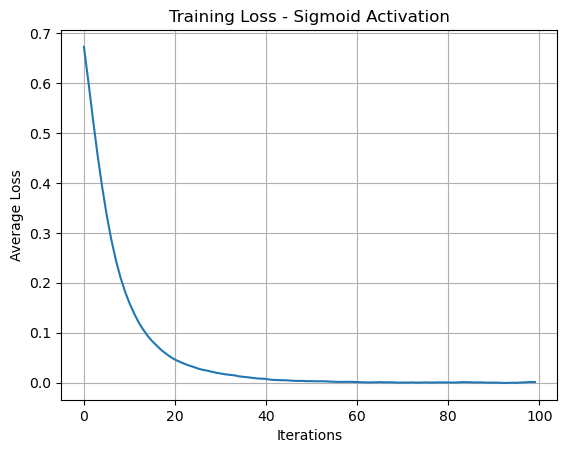

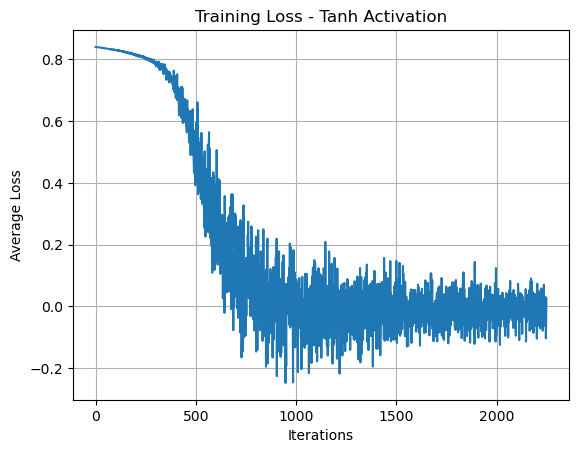

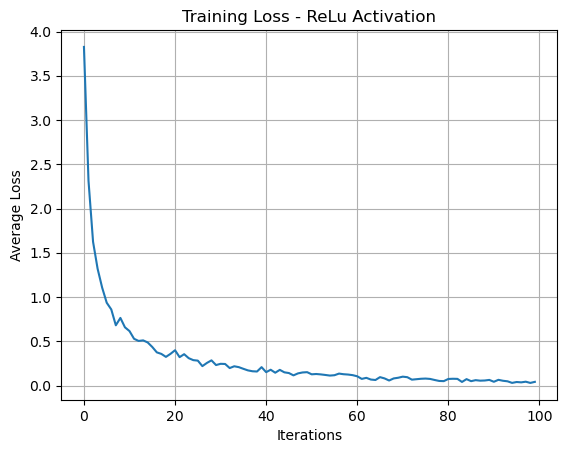

In [52]:
# sigmoid
sigmoidModel = FFN([8, 3, 8], alpha=0.1)
sigmoidModel.train(X=xTrain, y=yTrain, max_itterations=100)

# Tanh
tanhModel = FFN([8, 3, 8], activation="tanh", alpha=0.0001)
tanhModel.train(X=xTrain, y=yTrain, max_itterations=2250)

# ReLu 
reluModel = FFN([8, 3, 8], activation="relu", alpha=0.001)
reluModel.train(xTrain, yTrain, max_itterations=100)

In [32]:
Test = [[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0], 
        [0, 0, 1, 0, 0, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0, 0, 0], 
        [0, 0, 0, 0, 1, 0, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 0, 1, 0], 
        [0, 0, 0, 0, 0, 0, 0, 1]]

To inspect the performance of the models 

In [53]:
count = 0

for row in Test:
    sigmoid_prediction = sigmoidModel.predict(row)

    print("\033[1m Model with Sigmoid Activation \033[0m")
    print(f"Prediction: {sigmoid_prediction}")
    print(f"True Value {row}")
    if (np.array(row)==sigmoid_prediction).all():
        count += 1

    tanh_prediction = tanhModel.predict(row)

    print("\033[1m Model with TanH Activation \033[0m")
    print(f"Prediction: {tanh_prediction}")
    print(f"True Value {row}")
    if (np.array(row)==tanh_prediction).all():
        count += 1

    relu_prediction = reluModel.predict(row)

    print("\033[1m Model with ReLU Activation \033[0m")
    
    print(f"Prediction: {relu_prediction}")
    print(f"True Value {row}")
    if (np.array(row)==relu_prediction).all():
        count += 1

print(count)

 Model with Sigmoid Activation 
Prediction: [0. 0. 0. 0. 0. 0. 0. 1.]
True Value [1, 0, 0, 0, 0, 0, 0, 0]
 Model with TanH Activation 
Prediction: [0. 1. 0. 0. 0. 0. 0. 0.]
True Value [1, 0, 0, 0, 0, 0, 0, 0]
 Model with ReLU Activation 
Prediction: [0. 0. 0. 1. 0. 0. 0. 0.]
True Value [1, 0, 0, 0, 0, 0, 0, 0]
 Model with Sigmoid Activation 
Prediction: [0. 0. 0. 0. 0. 0. 0. 1.]
True Value [0, 1, 0, 0, 0, 0, 0, 0]
 Model with TanH Activation 
Prediction: [0. 1. 0. 0. 0. 0. 0. 0.]
True Value [0, 1, 0, 0, 0, 0, 0, 0]
 Model with ReLU Activation 
Prediction: [0. 0. 0. 1. 0. 0. 0. 0.]
True Value [0, 1, 0, 0, 0, 0, 0, 0]
 Model with Sigmoid Activation 
Prediction: [0. 0. 0. 0. 0. 0. 0. 1.]
True Value [0, 0, 1, 0, 0, 0, 0, 0]
 Model with TanH Activation 
Prediction: [0. 0. 0. 1. 0. 0. 0. 0.]
True Value [0, 0, 1, 0, 0, 0, 0, 0]
 Model with ReLU Activation 
Prediction: [0. 0. 0. 1. 0. 0. 0. 0.]
True Value [0, 0, 1, 0, 0, 0, 0, 0]
 Model with Sigmoid Activation 
Prediction: [0. 0. 0. 0. 0. 0. 0

In [34]:
xTest = [0, 0, 0, 1, 0, 0, 0, 0]

Prediction = sigmoidModel.predict(xTest)

print("\033[1m Model with Softmax Activation \033[0m")
print(f"Prediction: {Prediction}")
print(f"True Value {xTest}")

 Model with Softmax Activation 
Prediction: [0. 0. 0. 0. 0. 0. 0. 1.]
True Value [0, 0, 0, 1, 0, 0, 0, 0]


In [35]:
Prediction = tanhModel.predict(xTest)

print("\033[1m Model with Tanh Activation \033[0m")
print(f"Prediction: {Prediction}")
print(f"True Value {xTest}")

 Model with Tanh Activation 
Prediction: [0. 0. 1. 0. 0. 0. 0. 0.]
True Value [0, 0, 0, 1, 0, 0, 0, 0]


In [36]:
Prediction = reluModel.predict(xTest)

print("\033[1m Model with ReLu Activation \033[0m")
print(f"Prediction: {Prediction}")
print(f"True Value {xTest}")

 Model with ReLu Activation 
Prediction: [0. 1. 0. 0. 0. 0. 0. 0.]
True Value [0, 0, 0, 1, 0, 0, 0, 0]


In [37]:
sigmoidModel.displayModel()

{
    "Number of Layers": 3,
    "Layers": [
        {
            "Layer": 1,
            "Number of Nodes": 8,
            "Weights": [
                [
                    0.5894825213658984,
                    0.8107613110671875,
                    0.4968862104019545,
                    0.9828018338710162,
                    0.40023428086944707,
                    0.6085446221923794,
                    0.07455178449634463,
                    0.1524981765763688
                ],
                [
                    0.9226708647665899,
                    0.025795631613450738,
                    0.688886424339828,
                    0.5695206382581879,
                    0.04015595962738571,
                    0.04184071683052058,
                    0.3905445134447795,
                    0.7163838328680546
                ],
                [
                    0.24273324575937508,
                    0.5124876907098651,
                    0.9215132267877765,
      

In [38]:
def testing(n=100, plot=True):
    models = {
        'sigmoid': {'activation': 'sigmoid', 'alpha_scale': 0.1, 'max_iterations_scale': 40},
        'tanh': {'activation': 'tanh', 'alpha_scale': 0.0001, 'max_iterations_scale': 2250},
        'relu': {'activation': 'relu', 'alpha_scale': 0.001, 'max_iterations_scale': 15}
    }

    counts = {name: [] for name in models}
    a_values = np.linspace(0.5, 1.5, n)

    for a in a_values:
        for model_name, params in models.items():
            model = FFN(
                [8, 3, 8], 
                activation=params['activation'], 
                alpha=params['alpha_scale'] * a
            )
            model.train(X=xTrain, y=yTrain, max_itterations=int(params['max_iterations_scale']), plot_loss=False)

            count_correct = sum((np.array(row) == model.predict(row)).all() for row in Test)
            counts[model_name].append(count_correct)
    if plot:
        plt.figure(figsize=(10, 6))
        for model_name, count_list in counts.items():
            plt.plot(a_values, count_list, label=f"{model_name.capitalize()}")

        plt.xlabel("Alpha Value Scaling")
        plt.ylabel("Correct Predictions")
        plt.title("Correct Prediction Counts vs Alpha Value Scaling")
        plt.legend()
        plt.grid()
        plt.show()
    return a_values, counts


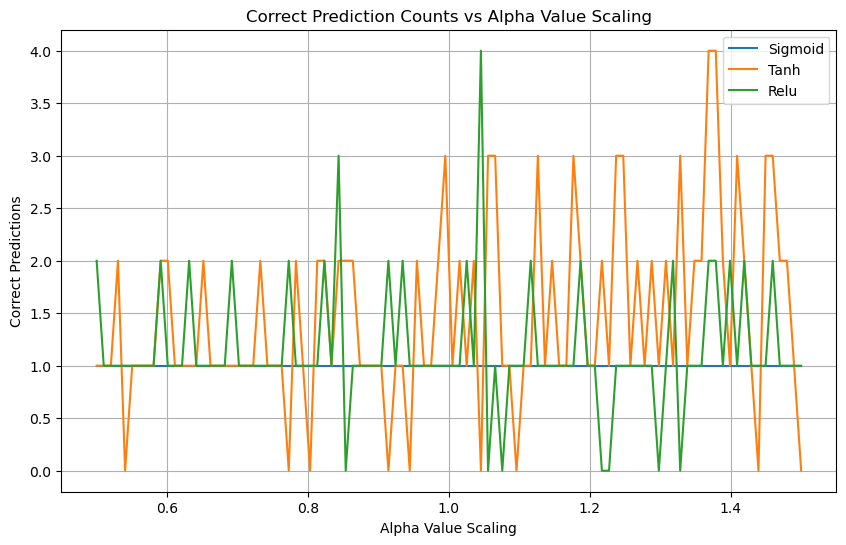

(array([0.5       , 0.51010101, 0.52020202, 0.53030303, 0.54040404,
        0.55050505, 0.56060606, 0.57070707, 0.58080808, 0.59090909,
        0.6010101 , 0.61111111, 0.62121212, 0.63131313, 0.64141414,
        0.65151515, 0.66161616, 0.67171717, 0.68181818, 0.69191919,
        0.7020202 , 0.71212121, 0.72222222, 0.73232323, 0.74242424,
        0.75252525, 0.76262626, 0.77272727, 0.78282828, 0.79292929,
        0.8030303 , 0.81313131, 0.82323232, 0.83333333, 0.84343434,
        0.85353535, 0.86363636, 0.87373737, 0.88383838, 0.89393939,
        0.9040404 , 0.91414141, 0.92424242, 0.93434343, 0.94444444,
        0.95454545, 0.96464646, 0.97474747, 0.98484848, 0.99494949,
        1.00505051, 1.01515152, 1.02525253, 1.03535354, 1.04545455,
        1.05555556, 1.06565657, 1.07575758, 1.08585859, 1.0959596 ,
        1.10606061, 1.11616162, 1.12626263, 1.13636364, 1.14646465,
        1.15656566, 1.16666667, 1.17676768, 1.18686869, 1.1969697 ,
        1.20707071, 1.21717172, 1.22727273, 1.23

In [50]:
testing(100)

In [40]:
from collections import defaultdict

In [51]:
def average_dicts(num_iterations):
    # Initialize a dictionary to store the cumulative sums
    cumulative_sums = defaultdict(lambda: [0] * 10)

    # Generate and accumulate the values
    for _ in range(num_iterations):
        a_values, current_dict = testing(10, plot=False)
        for key, values in current_dict.items():
            cumulative_sums[key] = [sum_val + new_val for sum_val, new_val in zip(cumulative_sums[key], values)]
    
    # Calculate the averages
    averages = {key: [sum_val / num_iterations for sum_val in values] for key, values in cumulative_sums.items()}
    return averages

# Example: Run this for 5 iterations
num_iterations = 10
average_result = average_dicts(num_iterations)
print(average_result)

{'sigmoid': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'tanh': [0.9, 0.9, 0.9, 1.1, 1.6, 1.0, 0.8, 1.8, 1.7, 1.8], 'relu': [1.1, 1.1, 0.9, 1.2, 1.1, 1.0, 1.1, 0.7, 1.3, 1.3]}


### Results
As it can be seen in the previous cell our model does not perform constantly well. In fact it never manages to predict all possible examples correctly. The Network performce on average the worst with the sigmoid activation function with always one correct prediction.